# Modeling Personal Loan Delinquency with LendingClub Data

## Background

The goal of our project is to model credit risk on peer-to-peer lending, namely, to evaluate the probability of borrower delinquency during a loan term. LendingClub loans are made over either a 36 or 60 month term, with a variety of statistics reported about each unique loan on a monthly basis. Our variable of interest is the `loan_status`, which has eight possible states. We aim to model the probability of a loan transitioning between any two of these states at any month during the loan term. Below are the states, with descriptions based on LendingClub's [website](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-):

![Loan States](resources/loan-states.png)


As examples below, we show a few common trajectories that a loan might take, the first a "good" borrower and the latter a "delinquent" borrower:

![Example Trajectory 1](resources/trajectory1.png)

![Example Trajectory 2](resources/trajectory2.png)

## Markov Chains

To model the monthly transition states, we initially employ a stationary discrete Markov Chain model. Discrete because our data is on a monthly basis, and stationary because we assume the probability of transition is independent of time (we use the same model across all months). Later on, we explore more flexible Markov Models. Recall the Markov property, or the "memoryless" assumption, that for some sequence of events, the conditional probability of the next time step $x_t$ depends only upon the previous time step $x_{t-1}$, ignoring all time steps that preceded it:

![Markov Property](resources/markov-property.png)

For a discrete Markov Chain, the joint distribution for the probability of some sequence length $T$ can then be written as:

![Markov Distribution](resources/markov-distribution.png)

[Murphy, 2012, p. 589](#References)

For $K$ outcome states, the conditional distribution $p(X_t | X_{t-1})$ can be written as a $K \times K$ transition matrix (denoted $A$) where $A_{jk}  = p(X_t = k | X_{t-1} = j)$ (the probability of transitioning from state $j$ to state $k$, where each row in the matrix can be thought of as an individual probability mass). In our case $K=8$ and we have an $8 \times 8$ transition matrix. The goal of our analysis, then, is to estimate the posterior probabilities of this transition matrix using observed data.

One way to visualize the transition matrix is through a graphical model, which we've created below to model the most commonly observed transition states:

![Transitions Graphical Model](resources/transition-graphical-model.png)

## Data

Our dataset consists of approximately 40 million observations from loans spanning between 2007 through Q3 2018. The dataset includes dozens of fields, however for our Markov models we only need to work with 4 features: `id`, `loan_status`, `term`, and `age_of_loan`.

During preprocessing, we filter out all loans with a 60 month term, as well as 36 term loans that extended beyond 36 months, reducing our dataset to around 27 million observations. In total, we have just under 1.5 million unique loans. This is also when we introduce the `Done` state for loans the terminate early.

In [1]:
from utils.utils import (
    load_dataframe, 
    preprocess, 
    split_data, 
    get_counts_per_month
)
from utils.models import (
    build_mle_matrix, 
    model_stationary_dirichlet_categorical_edward, 
    model_stationary_dirichlet_categorical_tfp, 
    model_non_stationary_dirichlet_categorical,
    model_stationary_dirichlet_multinomial
)

from utils.inference import (
    compute_mle, 
    infer_stationary_dirichlet_categorical_edward, 
    infer_stationary_dirichlet_categorical_tfp, 
    infer_non_stationary_dirichlet_categorical, 
    infer_stationary_dirichlet_multinomial
)

from utils.criticism import (
    sample_mle, 
    sample_and_plot_length, 
    graph_trajectory, 
    plot_probs_from_state_j,
    copy_model_ed,
    sample_ed,
    sample_and_plot_length_ed,
    copy_model_tfp,
    sample_tfp,
    sample_and_plot_length_tfp,
    plot_multinomial_probs
)

In [2]:
df = load_dataframe()

Loading raw data from cache...
Retrieved 40,219,838 rows, 4 columns in 3.43 seconds


In [3]:
df = preprocess(df)

Mapping column names...
Loading preprocessed data from cache...
Retrieved 27,602,069 rows, 4 columns in 1.85 seconds


In [4]:
x_train, x_test = split_data(df)

Loading split data from cache...
Retrieved 1,508,424 rows, 36 columns in 0.60 seconds
Train: (1357404, 36) | Test: (151020, 36)


In [5]:
chain_len = max(df.age_of_loan)
n_states = df.loan_status.unique().shape[0] + 1

## Experiment 1: Maximum Likelihood Estimate Markov Model 

### 1.1 Model

To gain intuition on the true transition probabilities given our training data, $N$, we start with MLE estimation. The MLE solution of a Markov Chain is simply the empirical frequencies of each transition. Formally, the probability of some particular sequence length $T$, with transition matrix $A$ and states $K$ is given by: 

![Sequence Distribution](resources/sequence-distribution.png)

It is relatively easy to show that the MLEs for $p_j$ (at state $j$) and $A_{jk}$ (at transition from states $j$ to $k$) are given by the observed frequencies:  

![Markov MLEs](resources/markov-mles.png)

[Murphy, 2012, pp. 592–593](#References)

#### Realized Transitions

In [6]:
realized_transitions = build_mle_matrix(x_train)

Loading transitions data from cache...
Retrieved 8 rows, 8 columns in 0.02 seconds


In [7]:
realized_transitions

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
Charged Off,0,0,0,0,0,0,0,124909
Current,690,21999047,1,636273,5250,144170,55857,542199
Default,26029,132,2062,70,0,4,456,24
Fully Paid,0,0,0,7261,9,87,65,510600
In Grace Period,0,252,0,11,20,53,37,5173
Late (16-30 days),4093,29060,0,1853,230,12046,107561,5237
Late (31-120 days),95286,22818,26850,1935,49,2953,299384,11885
Done,0,0,0,0,0,0,0,22838744


Note that `Charged Off` is a "sink" state, and we simply filled this row with zeros.

### 1.2 Inference

Now use the realized transitions to compute the MLE estimate of $A_{jk}$ for each combination of $j$ and $k$.

In [8]:
mle = compute_mle(realized_transitions)

In [9]:
mle

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
Charged Off,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Current,0.000030,0.940794,0.000000,0.027210,0.000225,0.006165,0.002389,0.023187
Default,0.904507,0.004587,0.071654,0.002432,0.000000,0.000139,0.015846,0.000834
Fully Paid,0.000000,0.000000,0.000000,0.014017,0.000017,0.000168,0.000125,0.985672
In Grace Period,0.000000,0.045438,0.000000,0.001983,0.003606,0.009556,0.006671,0.932744
Late (16-30 days),0.025568,0.181534,0.000000,0.011575,0.001437,0.075250,0.671920,0.032715
Late (31-120 days),0.206622,0.049480,0.058223,0.004196,0.000106,0.006403,0.649198,0.025772
Done,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


### 1.3 Criticism

#### 1.3.1 Interpreting Estimates

We can see that a lot of the MLE estimates reflect our expectations, for example:
- A loan which is `Current` is very likely to transtion to `Current`.
- A loan which is in `Default` is very likely to transition to `Charged Off`.
- A loan (typically) cannot transition straight from `Current` to `Late (31-120 days)`.

#### 1.3.2 Posterior Predictive Sampling 

We can now use these estimates to generate some trajectories. We start at `Current` and keep generating transitions for a period of 36 months, except if we reach `Charged Off` or `Fully Paid` which both are essentially a "sink".

**Sample 1**: An example of "good loan" that was paid back quickly.

Even though the trajectory seems likely, we can see that the loan is quite short. We will discuss loan lengths in the next criticisim section.

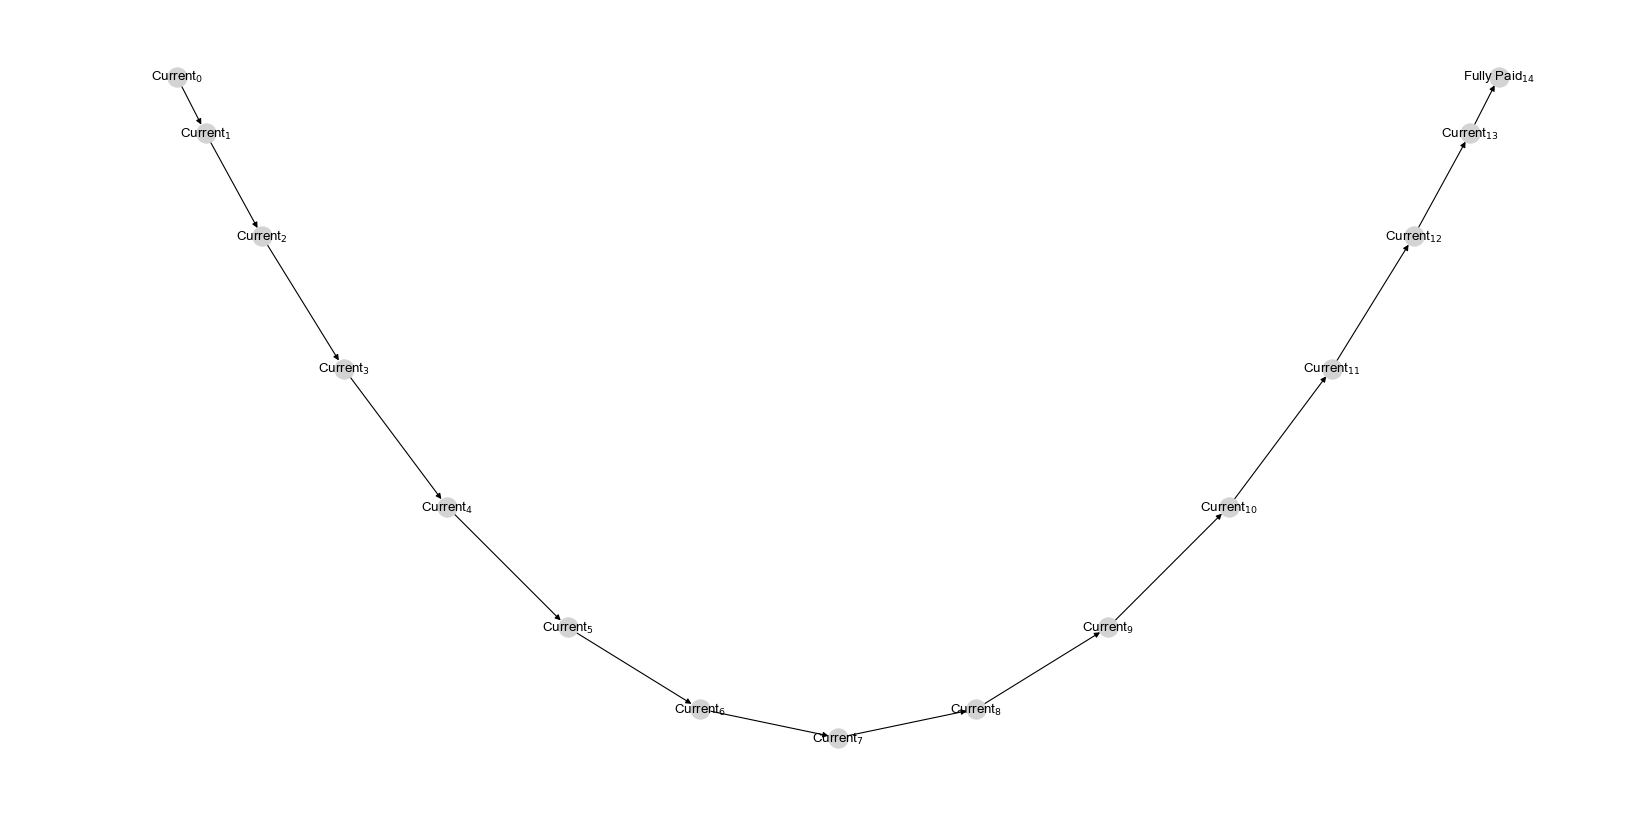

In [15]:
graph_trajectory(sample_mle(mle))

**Sample 2**: An example of "bad loan" that became late after a few months (different states of lateness) until getting charged off in month 12.

The transitions `Current` -> `In Grace Period` -> `Late (16-30 days)` -> `Late (31-120 days)` do meet our expectations, yet we can see that the loan only stays one month in the state `Late (31-120 days)` and is `Charged Off` very soon. In reality, we know that the loan would actually stay in that state for at least three months before being `Charged Off`.

This reflects the main drawback of the Markov assumption: the transitions are only conditioned on the current state and do not take into account the previous states, which in our case means that they do not condition on how many months were spent in that state. One way to remedy this would be higher-order Markov Chain that are conditioned on additional previous states, however this was not within the scope of our project.

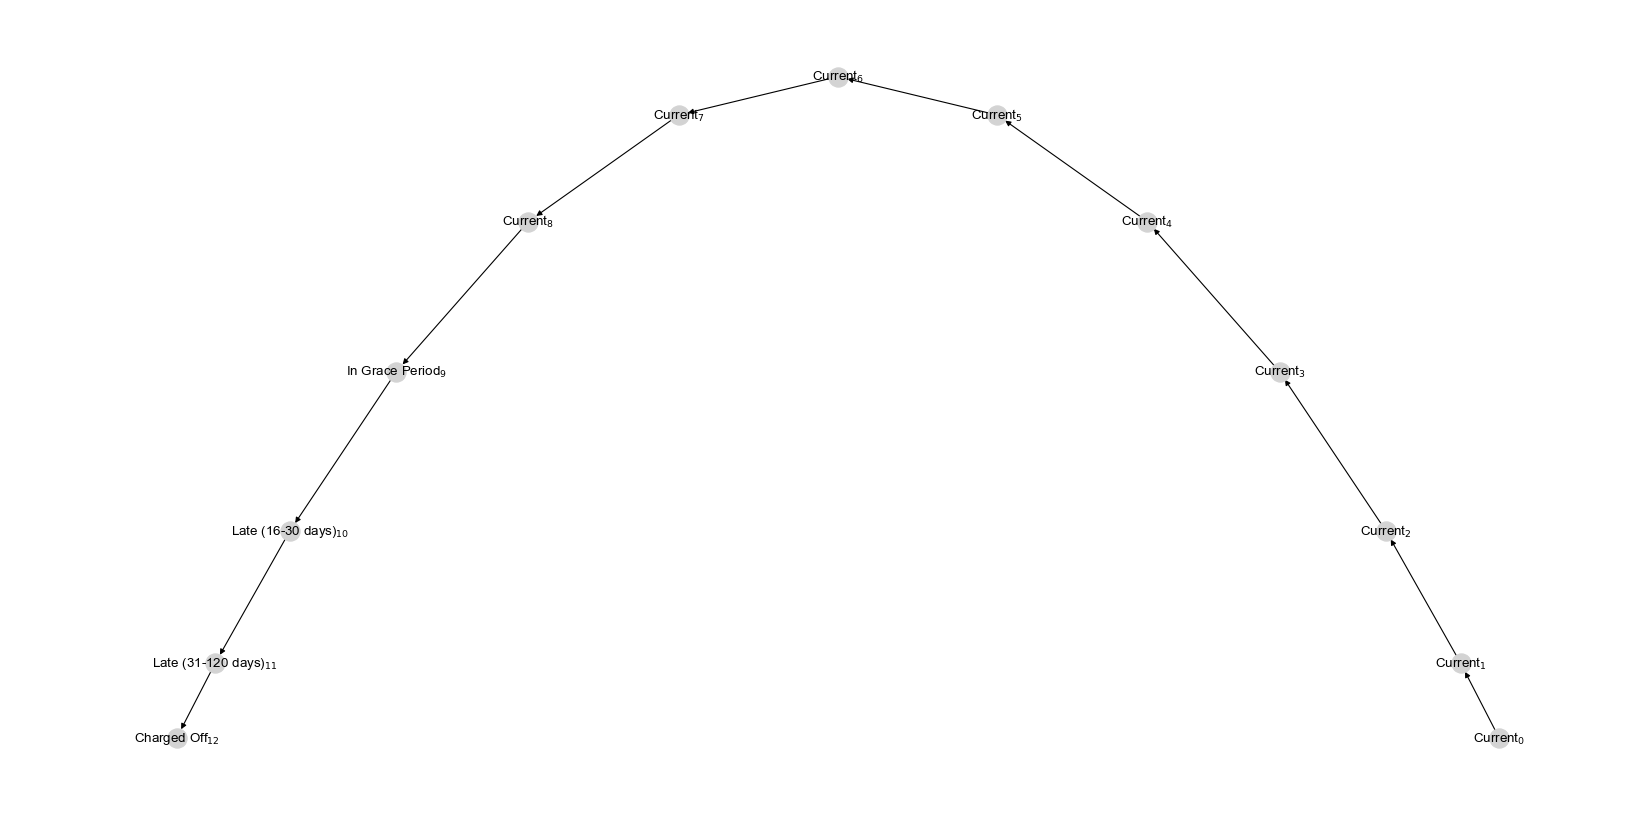

In [18]:
graph_trajectory(sample_mle(mle))

**Sample 3**: A loan that was late but got paid and got back to Current 

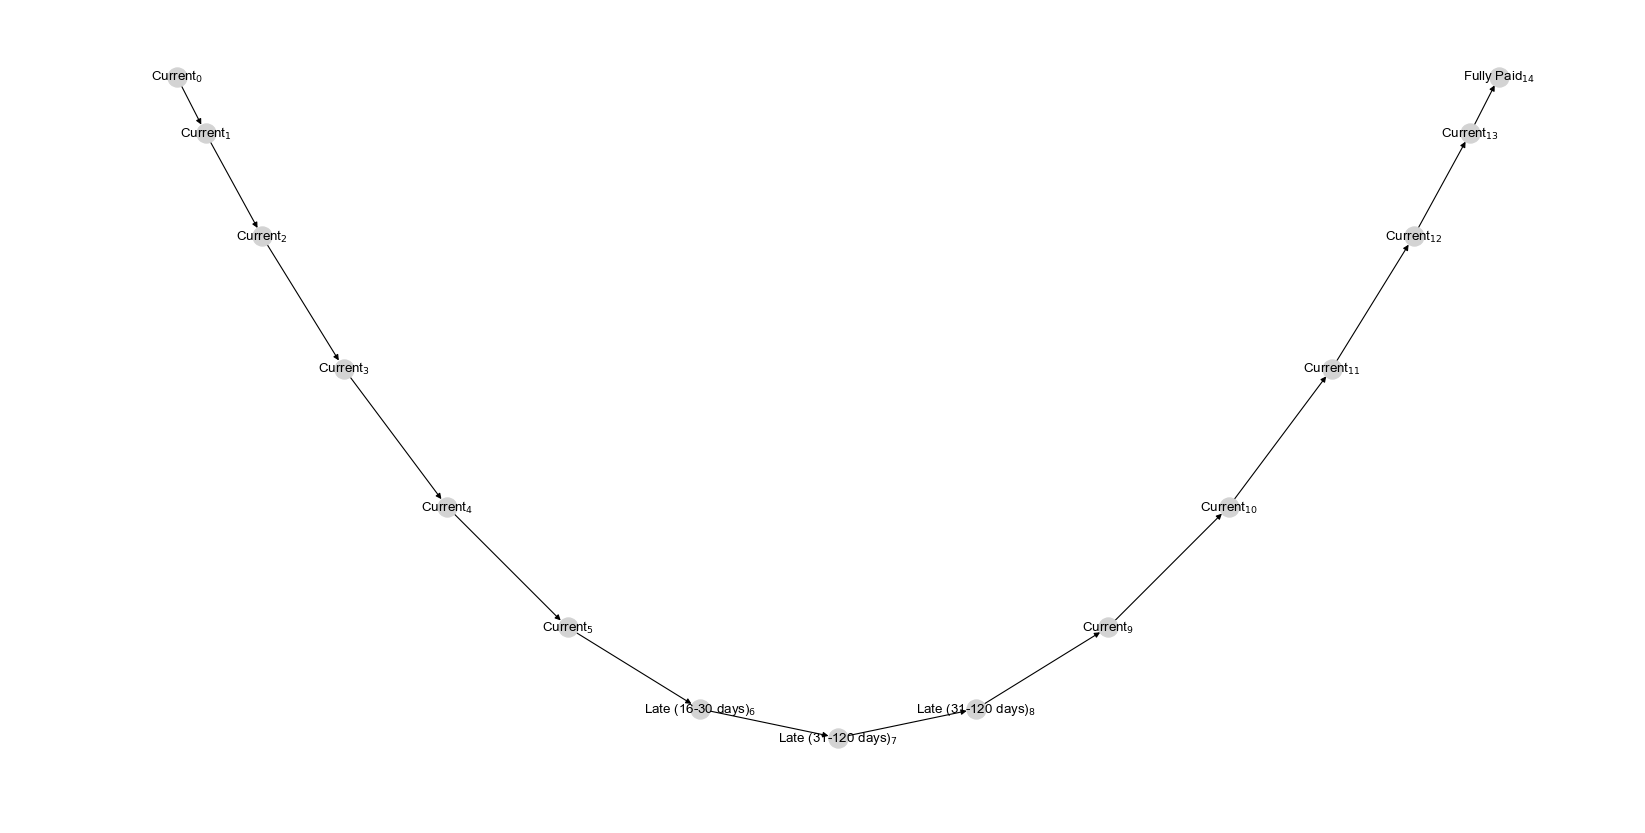

In [14]:
graph_trajectory(sample_mle(mle))

#### 1.3.3 Evaluating Loan Length

Since we have the ability to sample from our learned posterior predictive, it is interesting to look at the average length of loans across real data and sampled data. This echoes work by [Rubin (1984)](#References) and later [Gelman et al (1996)](#References) presented in Lecture 7.

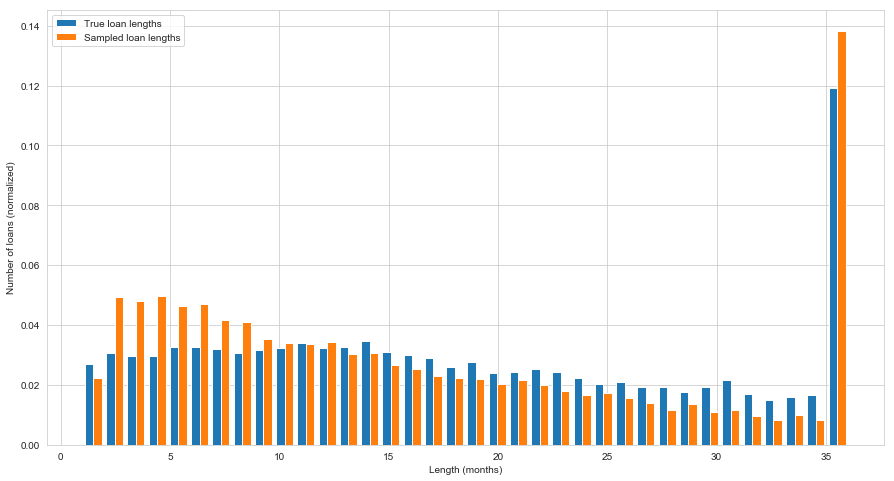

Average length of sampled loans: 16.33 months
Average length of true loans: 18.30 months


In [11]:
sample_and_plot_length(mle, x_train)

We see on this histogram that the posterior predictive tends to predict shorter loans: in particular, loans shorter than 10 months seem much more likely. This again shows the main drawback of the Markov assumption: the likelihood of a loan moving from `Current` to a delinquent state is independent of the age of the loan. Therefore, the model tends to overestimate the probability of delinquency for early months.

## Experiment 2: Stationary Dirichlet-Categorical Markov Model (Edward)

### 2.1 Model

Our first Bayesian model uses the Categorical Distribution to model state transitions, with the Dirichlet Distribution as priors. 

Recall the Categorical Distribution, denoted Cat$(p_1, ..., p_K)$, is a generalization of the Bernoulli Distribution across outcome states, namely, it describes the possible results of a single trial random variable $X$ that can take on one of $K$ possible outcome states, with the probability of each category given by $(p_1, ..., p_K)$. In our scenario, $K=8$ represents the possible `loan_status` states. The probability mass function is then given by:

![Categorical Distribution](resources/categorical.png)

The Dirichlet Distribution, denoted Dir$(a_1, ..., a_K)$, is the conjugate prior of the Categorical Distribution. It describes the probabilities for a K-dimensional vector of random variables $\bar{X}$ with entries in (0,1) and which sum to 1. It should be clear why this makes sense for modelling our Categorical priors. It is parameterixed by $(a_1, ..., a_K)$, the concentration paramters, which become hyperparameters in our model. The probability density function is given by:

![Dirichlet Distribution](resources/dirichlet.png)

The Markov Chain model we specify for transition matrix $A$, outcome states $K=8$ over sequence of months $T=36$ is given by:

![Model 2](resources/model2.png)

Here $p_0$ is our initial prior, and $A_j = [p_1, ..., p_K]$ (the $j$th row of the transition matrix) is not time-dependent since we assume a stationary model.

[Tu, 2018](#References)

[Murphy, 2012, p. 594](#References)

In [7]:
batch_size = 1000

In [8]:
x, pi_0, pi_T = model_stationary_dirichlet_categorical_edward(n_states, chain_len, batch_size)

### 2.2 Inference

#### 2.2.1 Batch Training

We applied the KLqp variational inference algorithm in Edward to minimize the KL divergence. One caveat while we were implementing the inference function was that due to the size of our dataset, it too a very long time to run. To address this issue, we implemented Edward's [batch training](http://edwardlib.org/tutorials/batch-training) feature, which instead trains the model using only a subsample of data for each update. This significantly reduced training time. We applied the same batch training methodology for all subsequent experiments as well.

#### 2.2.2 Parameter Tuning

We initialized the priors at random, and tried different values for parameter tuning, on `n_samples` (used for Monte Carlo estimation in the loss computation), on the `learning_rate`, and on the learning algorithm itself (variants of Gradient Descent). We observed that the training was very sensitive to the learning rate (either not converging, or worse, reaching a `NaN` loss.

We observed that, despite a lot of parameter tuning, the ELBO is quite hard to optimize and the loss keeps oscillating, as shown on the following training curve. Yet, there is a clear decreasing trend indicating that the posterior approximations are indeed slowly converging to the model's posteriors. Nevertheless, one major drawback is that because of this unstable loss, there is no guarantee on the quality of our estimates at the very last iteration of the algorithm.

![Exp 2 loss, intialized at random](resources/exp_2_loss.png)

In [9]:
inferred_qpi, sess, qpi_0, qpi_T = infer_stationary_dirichlet_categorical_edward(
    x_train, x, pi_0, pi_T, n_states, chain_len, batch_size, lr=0.002, n_epoch=20)
inferred_qpi_0 = inferred_qpi[0]
inferred_qpi_T = inferred_qpi[1]

Loading experiment2 data from cache...
Loading cached edward model...
Retrieved data in 0.16 seconds


### 2.3 Criticism

#### 2.3.1 Interpreting Estimates

We look at the mean of each of the inferred posteriors, for both the initial state, $p_0$, and for the transition matrix $A_{jk}$:

In [10]:
inferred_qpi_0

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
probs,0.029079,0.758049,0.052101,0.020745,0.053845,0.031751,0.037764,0.016665


In [11]:
inferred_qpi_T

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
Charged Off,0.126364,0.130872,0.105530,0.151373,0.074542,0.091505,0.126446,0.193369
Current,0.023572,0.771536,0.028207,0.053869,0.014999,0.029450,0.023954,0.054413
Default,0.117822,0.114058,0.095189,0.206018,0.059596,0.152124,0.148413,0.106780
Fully Paid,0.109348,0.128055,0.085448,0.171202,0.069363,0.081580,0.128117,0.226889
In Grace Period,0.144683,0.164091,0.101207,0.083340,0.165186,0.111688,0.114226,0.115581
Late (16-30 days),0.144706,0.126425,0.200974,0.055100,0.080785,0.102520,0.129923,0.159569
Late (31-120 days),0.151580,0.137189,0.092395,0.081171,0.120349,0.074567,0.161937,0.180810
Done,0.025881,0.027788,0.023714,0.023678,0.017878,0.027877,0.023554,0.829630


We see that the mean transition matrix does follow some trends that we observed in the MLE estimate, for example `Current` -> `Current` is likely, and `Late (31-120 days)` either stay in place or transitions to `Charged Off`.

For other states, trends we would expect to see are missing, for example higher transition probabilities from `Charged Off` although it is a sink state.

We can also see that the algorithm inferred the initial distribution quite well.

#### 2.3.2 Posterior Predictive Sampling 

One drawback of this implementation (compared to Experiment 3) is that we need some custom code to sample correctly from the distribution, which almost required re-writing the model, but for the posterior predictive.

In [12]:
x_0_post, x_post = copy_model_ed(qpi_0, qpi_T, chain_len, n_states, batch_size)

**Sample 1**

Even though results for the mean transition matrix itself are reasonable, sampled trajectories are often counter intuitive. For example, a loan might be `Charged Off` and go back to non-delinquent states.

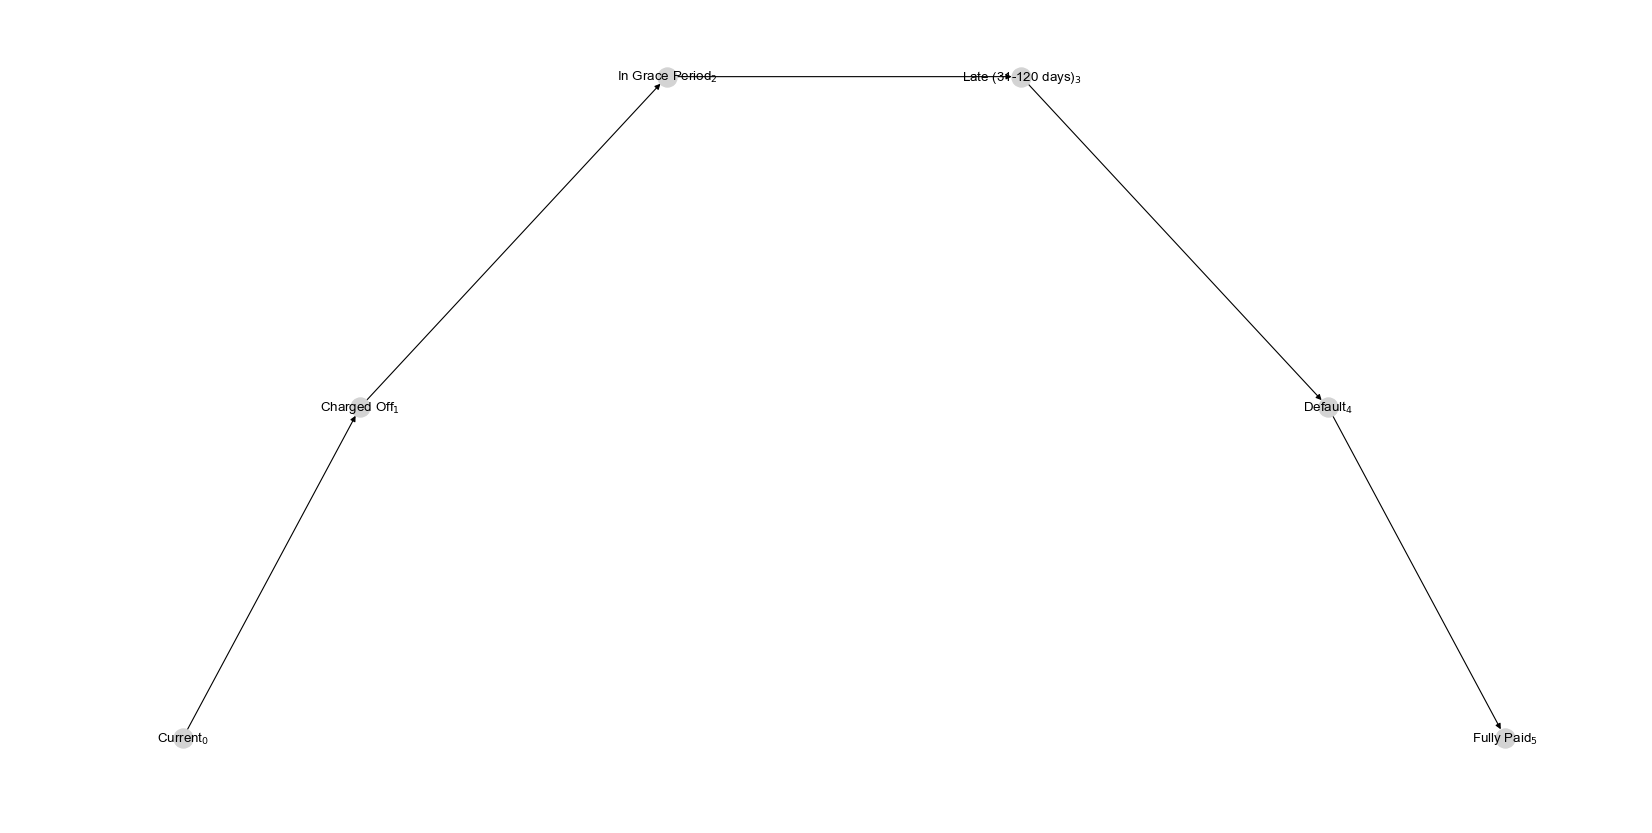

In [13]:
graph_trajectory(sample_ed(x_0_post, x_post, sess, inferred_qpi_0))

**Sample 2** An intuitive yet very short sample due to shortcomings of the Markov Assumption.

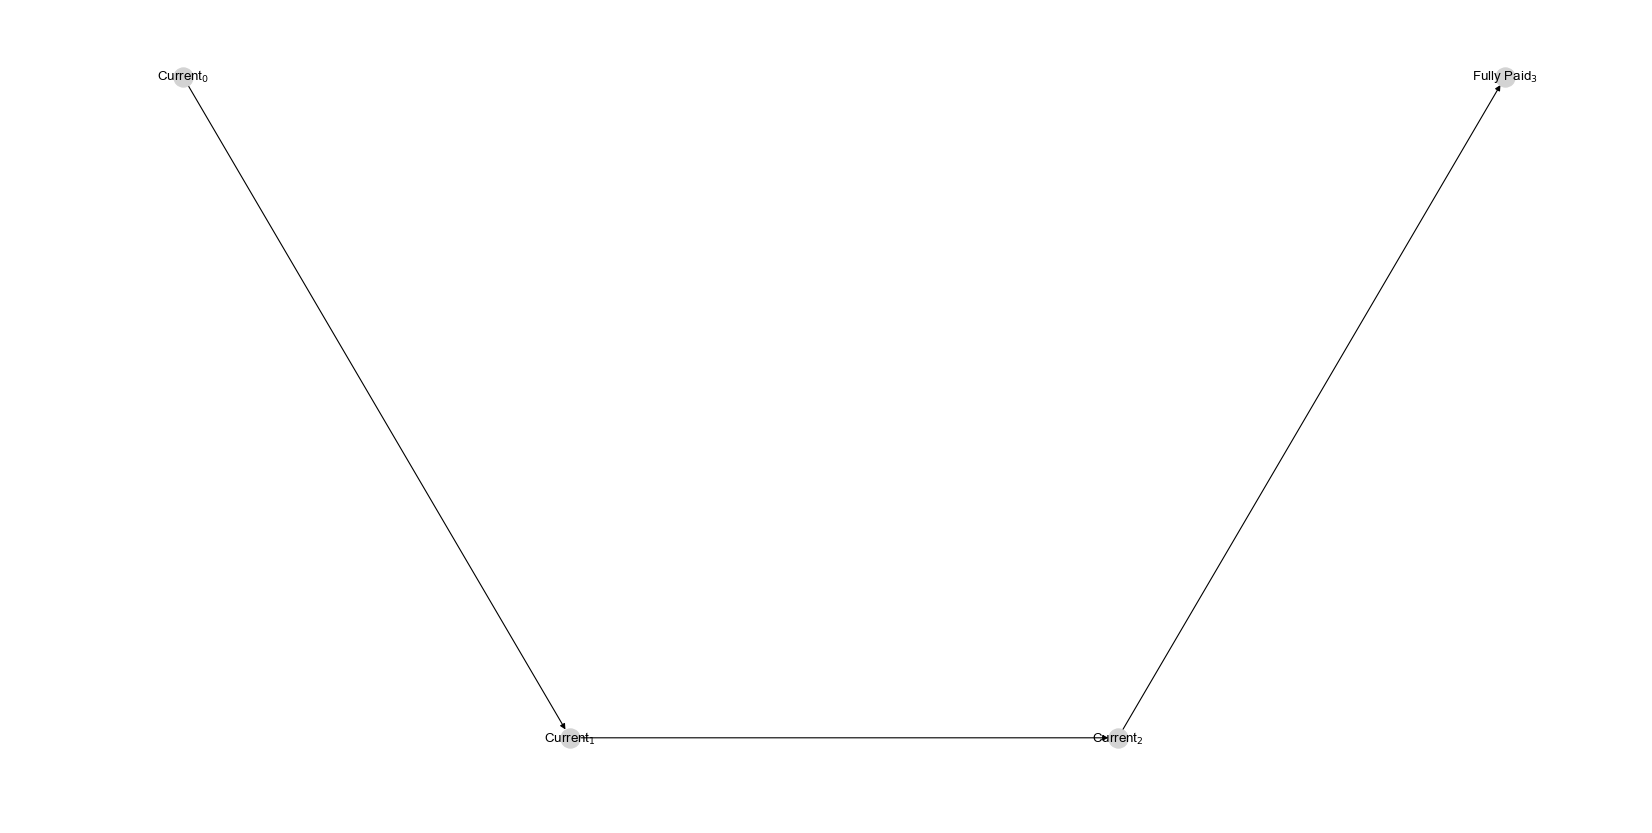

In [15]:
graph_trajectory(sample_ed(x_0_post, x_post, sess, inferred_qpi_0))

#### 2.3.3 Evaluating Loan Length

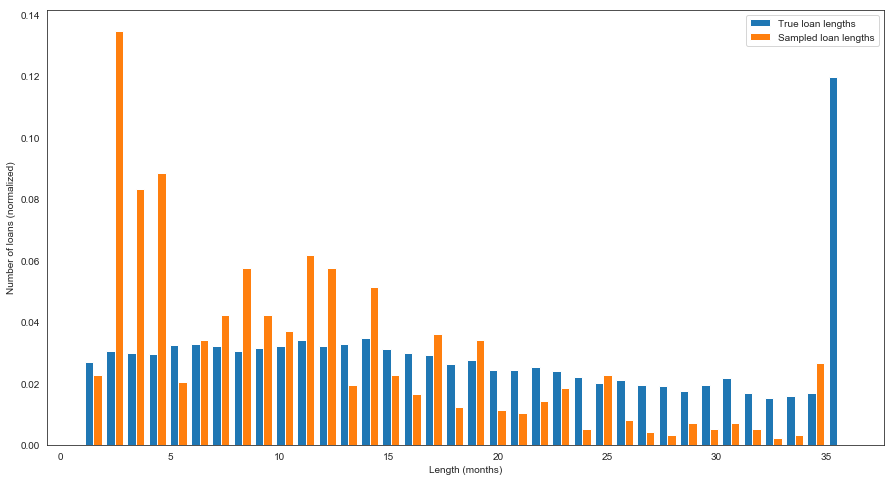

Average length of sampled loans: 10.97 months
Average length of true loans: 18.30 months


In [23]:
sample_and_plot_length_ed(x_0_post, x_post, sess, x_train, inferred_qpi_0)

Again, the model tends to overestimate the number of short loans, which is due to the model itself and similar to Experiment 1's findings. The average length is smaller than in Experiment 1 because a lot of states have a non-zero probability of transitioning to `Done`, which was not the case with MLE.

## Experiment 3: Stationary Dirichlet-Categorical Markov Model (Unreleased TFP code)

### 3.1 Model

This experiment uses the same model as Experiment 2, but our implementation is different. Rather than using a list of Categorical Random Variables that share the same prior implemented "by hand," we instead define a custom Edward Random Variable that directly implements the log-likelihood of a sequence of observations (instead of deriving it automatically from the graph) and can sample a sequence in one step. The goal with this Experiment was to implement the model in a way that is more "Edward native" to hopefully see a more stable decline in the loss, less variability in our results and hopefully a speed improvement.

Our custom Random Variable code is based on code that has been released on the [Tensorflow Probability repository](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/distributions/hidden_markov_model.py) very recently. The TFP implementation was intended as a Hidden Markov Model, but we apply a "trick" by setting its emission distribution to a constant Identity Matrix.

In [9]:
model, pi_0, pi_T = model_stationary_dirichlet_categorical_tfp(
    n_states, chain_len, batch_size=batch_size)

### 3.2 Inference

We first **initialized the priors at random**, similar to Experiment 2, which corresponds to the **blue** training curve below and again observe that the ELBO is hard to train and oscillates. In order to smooth the training, we then **initialized the priors with prior knowledge about the model**, namely, we set higher `alpha` values for the Dirichlet priors for the transitions that we know are very likely. As shown in **green**, the loss does decrease but much less than previously, and both methods seem to converge to the same loss value. Note that we tried these two initialization methods in Experiment 2 also, but the effect was much less visible than here.

Training is suprisingly much slower in this case than in Experiment 2. It seems like deriving the KLqp loss for the set of categoricals that we implemented in Experiment 2 is less computationally intensive than using the predefined complete log-likelihood to compute the gradients. We trained for 5 epochs which takes about 15 minutes. (more epochs (n_epoch=30) didn't improve the loss convergence).

![Exp 3 loss, intialized with prior knowledge](resources/exp_3_loss.png)

In [10]:
inferred_qpi, sess, qpi_0, qpi_T = infer_stationary_dirichlet_categorical_tfp(
    x_train, model, pi_0, pi_T, n_states, chain_len, batch_size=batch_size,
    lr=0.005, n_epoch=5)

inferred_qpi_0 = inferred_qpi[0]
inferred_qpi_T = inferred_qpi[1]

Loading experiment3 data from cache...
Loading cached edward model...
Retrieved data in 0.07 seconds


### 3.3 Criticism

#### 3.3.1 Interpreting Estimates

In [9]:
inferred_qpi_0

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
probs,0.159405,0.122083,0.110177,0.157024,0.099248,0.114111,0.159811,0.078141


In [10]:
inferred_qpi_T

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),Done
Charged Off,0.175394,0.167649,0.127722,0.151973,0.082431,0.093290,0.065007,0.136535
Current,0.041731,0.578401,0.052033,0.089443,0.036901,0.075969,0.038981,0.086541
Default,0.108751,0.068371,0.113739,0.063482,0.117682,0.206952,0.092890,0.228133
Fully Paid,0.123663,0.059769,0.112114,0.100985,0.189932,0.072944,0.143112,0.197481
In Grace Period,0.110073,0.193310,0.167544,0.062931,0.090391,0.125587,0.131544,0.118620
Late (16-30 days),0.107183,0.173610,0.111027,0.082505,0.155796,0.137834,0.083230,0.148815
Late (31-120 days),0.181020,0.205464,0.096042,0.056862,0.183738,0.072763,0.141292,0.062819
Done,0.073819,0.036282,0.068117,0.044633,0.048264,0.085935,0.048262,0.594688


The mean of the posterior follows some expected trends, yet the results are a bit further from our MLE baseline than in Experiment 2. We can also see that **the algorithm failed to infer the initial distribution properly**, which probably impacted the rest of the inference. We discuss further in the conclusion.

#### 3.3.2 Posterior Predictive Sample & Evaluating Loan Length

One advantage of this implementation over Experiment 2 is that it handles sampling a complete sequence of observations at once, therefore Edward can automatically integrate out over the posterior to compute the posterior predictive. Our results for this part being similar to Experiment 2, we skip this analysis for brevity: we observed short loans, and some counter-intuitive samples.

## Experiment 4: Non-Stationary Dirichlet-Categorical Markov Model

### 4.1 Model

Instead of each Categorical distribution sharing a single transition matrix across all timesteps, we now create a unique transition matrix for each timestep $(1,...,36)$, with their own respective Dirichlet prior. In other terms, we are now conditioning both on the previous step and on the position in the chain. The new Markov Chain model we specify for transition matrix $A$ (at each row $j$), outcome states $K=8$ over sequence of months $T=36$ is given by:

![Model 4](resources/model4.png)

This model should capture dynamics of the sequence of transitions better, since we can expect that the probability of different state transitions highly depends on the time elapsed since the beginning of the loan. For instance, it intuitively seems much more likely that a loan will remain `Current` in the next month if it has already been `Current` over 30 months, compared with a loan that has only been `Current` for, say, a single month. 

In [27]:
batch_size = 1000

In [28]:
x, pi_0, pi_T_list = model_non_stationary_dirichlet_categorical(n_states, chain_len, batch_size)

### 4.2 Inference

We again apply the Edawrd KLqp algorithm for inference, the only big difference now is that we have more variables and therefore training takes longer, but with our batch processing it still completes in a reasonable amount of time.

In [29]:
inferred_matrices, sess, qpi_0, qpi_T_list = infer_non_stationary_dirichlet_categorical(
    x_train, x, pi_0, pi_T_list, n_states, chain_len, batch_size, n_epoch=5, lr=0.005)

6767/6785 [ 99%] █████████████████████████████  ETA: 0s | Loss: 41205.648
Caching experiment4 data...
Retrieved data in 178.89 seconds


### 4.3 Criticism

For this experiment we assess the non-stationary nature of the transition probabilities across all months. We do this by plotting the the change in transition probability from some source state $j$ to any number of target states $k \in [1, ..., K]$ over the $36$ month term using the respective mean posterior transition matrix.

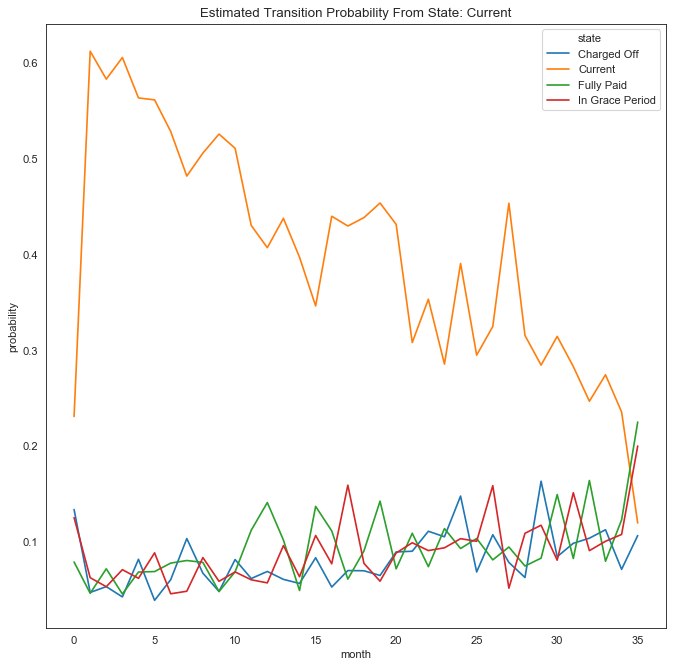

In [32]:
plot_probs_from_state_j(inferred_matrices, 'Current', ['Current', 'In Grace Period', 'Charged Off', 'Fully Paid'])

In the first plot above, we observe transition probabilities over time from the `Current` state to `Charged Off`, `In Grace Period`, `Fully Paid` or back to `Current`. Interestingly, the probability of returning to `Current` descreases over time, which is counter to the intutition we proposed above in the Model section. It is possible that our hypothesis above was simply wrong, and maybe in reality this reflects that it simply gets harder for individuals to stay current on loans as they get deeper into their term.  However, these results could also be a shortcoming of our model, namely, that despite the non-stationarity of the transition matrix, it still doesn't capture the multi-time step, or higher-order, dependencies between the late states, and may overestimate the probability of transitioning to those states while underestimating the probability of staying current as we get deeper into the loan term. 

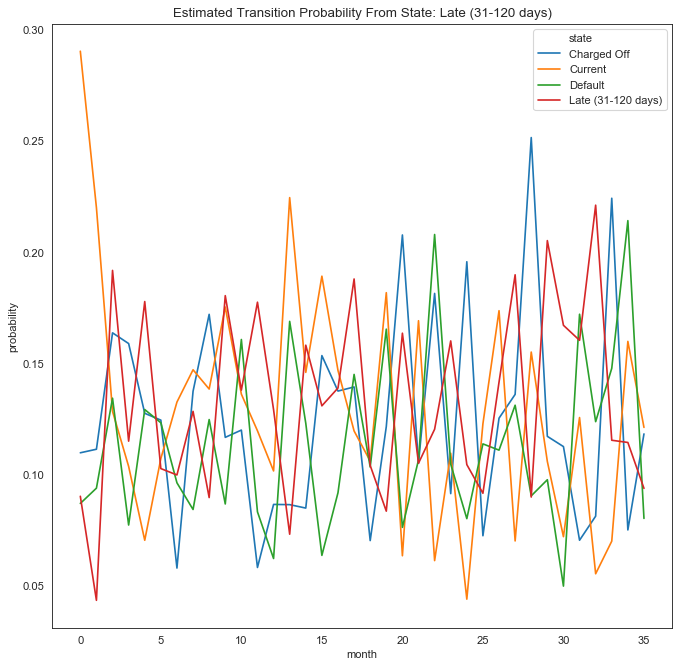

In [20]:
plot_probs_from_state_j(inferred_matrices, 'Late (31-120 days)', ['Current', 'Default', 'Charged Off', 'Late (31-120 days)'])

The second plot above showing transition probabilities from `Late (31-120 day)` to either `Current`, `Default`, `Charged Off` or itself is further evidence for the likely shortcomings of our first-order model, as we would expect the probability of moving into `Charged Off` or `Default` to increase over time (as a loan has been late longer and longer), but our model only knows about the $t-1$ time step and therefore can't capture the higher-order structure, the result being that we really don't see any clear trends in these transition probabilities over time.

## Experiment 5: Modeling state counts as a Dirichlet-Multinomial Model

### 5.1 Model

For this experiment, instead of modelling loans at a "local" scale, we look at a summary of all loans. Our initial idea, based on the work of [Grimshaw and Alexander](#References), is for each month $t$, and for each state $j$, to model the number of loans that will move from this state to every other state as a Multinomial distribution.

Since we know from previous experiments that modeling such a sequence of Multinomials might be challenging, we make the model much simpler but based on the same "global scale" idea: We model the loan count in each state as a Multinomial. Therefore, we completely remove sequential dependencies and only condition our observations on the loan's age.

Recall the Multinomial Distribution, denoted Mult($p_1, ..., p_K, n$) is a generalization of the Categorical Distribution in terms of the number of trials, $n$, which for the Categorical was just one at each timestep. The Multinomial is given by:

![Multinomial Distribution](resources/multinomial.png)

In our model, $n$ denotes the total number of loans active on the Lending Club, and we define $x_j^t$ as the number of loans in state $j$ in month $t$.

Each vector of counts $\bar{X}^t = [x_1^t, ..., x_T^t]$ for each month $t$ is drawn from a corresponding independent multinomial with probabilities $[p_1^t, ..., p_T^t]$ themselves drawn from a Dirichlet prior:

![Model 5](resources/model5.png)

In [6]:
pi_list, counts = model_stationary_dirichlet_multinomial(
    n_states, chain_len, total_counts_per_month=x_train.shape[0])

### 5.2 Inference

We count the number of loans in each state at each month, then run KLqp Variational Inference on our simple model.

In [7]:
counts_per_month = get_counts_per_month(x_train, n_states)

In [8]:
inferred_matrix, sess, qpi_list = infer_stationary_dirichlet_multinomial(
    counts_per_month, pi_list, counts, x_train.shape[0], n_states, chain_len)

Loading experiment5 data from cache...
Loading cached edward model...
Retrieved 36 rows, 8 columns in 0.41 seconds


Inference for this model is much more stable than all other experiments, as we could expect, since there are no sequential dependencies and the model is fairly simple.

### 5.3 Criticism

We now have a matrix that gives us, for each given month and each given state, the probability of a loan to be in that state at that month, regardless of the loan's history. Therefore our model reflects "global trends" that can be seen accross all loans. One interesting inference is to look at the evolution of the probabilities month after month:

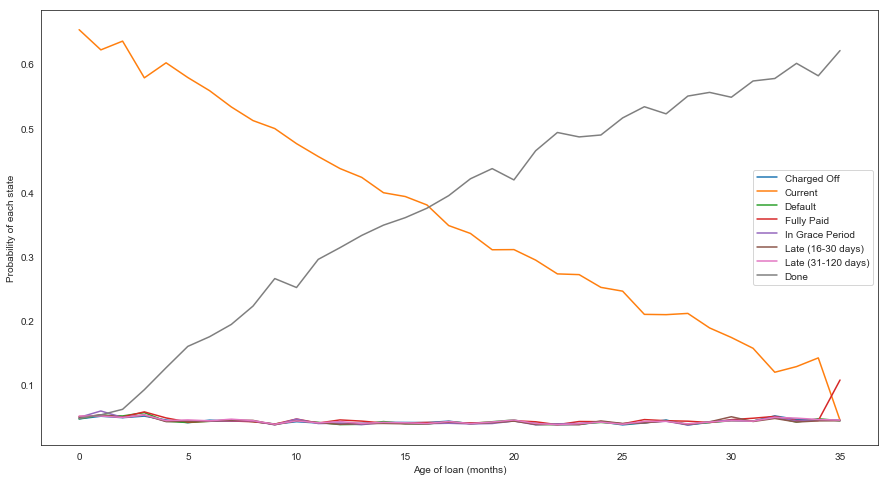

In [9]:
plot_multinomial_probs(inferred_matrix)

We found that, due to the simplicity of this model, it only captures a few very basic trends. However, these are consistent with some of the trends we saw in Experiment 4, for instance the declining probability of transitioning from `Current` to `Current` in the non-stationary model seems in alignment with the decreasing probability of `Current` in this model. 

Our simple Dirichlet-Multinomial formulation could serve as a foundation for more complex models of similar form, as we discuss in the next section.

## Conclusions & Future Work

TODO

## References

*Machine Learning: A Probabilistic Perspective*, by Kevin P. Murphy, MIT Press, 2012.

*The Dirichlet-Multinomial and Dirichlet-Categorical models for Bayesian inference*, by Stephen Tu, retrieved from https://people.eecs.berkeley.edu/~stephentu/writeups/dirichlet-conjugate-prior.pdf

*Rubin, Donald B. Bayesianly justifiable and relevant frequency calculations for the applied statistician. The Annals of Statistics, 12(4):1151–1172, 1984.*

*Gelman, Andrew, Meng, Xiao-Li, and Stern, Hal. Posterior predictive assessment of model fitness via realized discrepancies. Statistica Sinica, 6(4):733–760, 1996.*

*Scott D. Grimshaw, William P. Alexander, Markov Chain Models for Delinquency: Transition Matrix Estimation and Forecasting*